In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

from skimage import segmentation
import skimage
import os
import argparse
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from model_multi import DilateSR as Net
from simplenet_train import Tailor as Net
from simplenet_train import DilateSR, ResUNet, MyNet
import myDataLoader
from crf import dense_crf

os.environ['CUDA_VISIBLE_DEVICES']='0'
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(0)

In [2]:
args = argparse.Namespace()
args.batch_size = 1
args.img_channel = 3
args.img_size = 512

args.num_channel = 100
args.max_iteration = 1
args.min_label = 20

args.lr = 0.1
args.num_conv = 2
args.num_superpixel = 5000
args.compactness = 10

args.visualize = 0
args.cuda = True
args.csv_path = 'data/image_files_pilot.csv'
args.workers = 1

In [3]:
def slic(im):
    labels = segmentation.slic(im, compactness=args.compactness, n_segments=args.num_superpixel)
    labels = labels.reshape(im.shape[0]*im.shape[1])
    u_labels = np.unique(labels)
    l_inds = []
    for i in range(len(u_labels)):
        l_inds.append( np.where( labels == u_labels[ i ] )[ 0 ] )
    return l_inds

In [4]:
def label(epoch, files):
    with torch.no_grad():
        for i, f in enumerate(files):
            f = os.path.join(file_dir, f)
            im = cv2.imread(f)
            data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) ).cuda()
            if epoch==0:
                l_inds = slic(im)
                np.save(os.path.join(slic_path, str(i) + '.npy'), l_inds, allow_pickle=True)
            else:
                l_inds = np.load(os.path.join(slic_path, str(i) + '.npy'), allow_pickle=True)
            if epoch == 0:
                cv2.imwrite(os.path.join(image_path, str(i) + '.jpg'), im)

            output = encoder( data )[ 0 ]
            output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.num_channel ) 
            ignore, target = torch.max( output, 1 ) 
            im_target = target.data.cpu().numpy()
            nLabels = len(np.unique(im_target)) 
            for k in range(len(l_inds)):
                labels_per_sp = im_target[ l_inds[ k ] ] 
                u_labels_per_sp = np.unique( labels_per_sp ) 
                hist = np.zeros( len(u_labels_per_sp) )
                for j in range(len(hist)):
                    hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] ) 
                im_target[ l_inds[ k ] ] = u_labels_per_sp[ np.argmax( hist ) ] 

            im_target = im_target.reshape((args.img_size, args.img_size))
            cv2.imwrite(os.path.join(label_path, str(i) + '.png'), im_target)
            sys.stdout.write('\r[%d][%d/%d]' % (epoch, i, len(files))) 

In [5]:
def train(epoch, dataloader, l):
    if args.cuda:
            Tensor = torch.cuda.FloatTensor
    else: Tensor = torch.FloatTensor
    img_count = 0
    for i, batch in enumerate(dataloader):
        
        optimizer_encoder.zero_grad()
        optimizer_model.zero_grad()
        inputs, pmaps = batch['image'].type(Tensor), batch['pmap'].type(Tensor)    
        
        inputs = inputs.type(Tensor)   
        channel, _ = model(inputs) # N X C X H x W  
        channel = channel.permute(0, 2, 3, 1).contiguous().view(args.batch_size, -1, args.num_channel)
        # N X HW X C
        
        
        target = pmaps.type(Tensor)
        target = target.view(args.batch_size, -1).long()
        
        ignore, output = torch.max( channel, 2 )
        output = output.view(1, 1, -1).float()
        num_class = len(np.unique(output.detach().cpu().numpy()))
        
        channel = channel.view(-1, args.num_channel)
        target = target.view(-1)
        if num_class >= args.min_label: 
            loss = loss_fn(channel, target)
            loss.backward(retain_graph=False) 
            optimizer_encoder.step()
        else: 
            loss = -loss_fn(channel, target)
            loss.backward(retain_graph=False) 
            optimizer_encoder.step()
        
        iteration = 0
        while iteration < args.max_iteration:
            iteration = iteration + 1
            optimizer_model.zero_grad()
            _, reconst = model(inputs)
            reconst_loss = loss_identity(reconst, inputs)
            reconst_loss.backward()
            optimizer_model.step()            

        img_count = img_count + 1

        sys.stdout.write('\r[%d][%d/%d][%d]' % (epoch, img_count, len(dataloader), num_class))

In [6]:
def test(test_dir, is_crf, output_dir, aux_filename):
    with torch.no_grad():
        label_colours = np.random.randint(255,size=(100,3))
        test_file = [os.path.join(test_dir, f) for f in sorted(os.listdir(test_dir))]
        for f in test_file:
            torch.cuda.empty_cache()
            im = cv2.imread(f)
            data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
            if use_cuda:
                data = data.cuda()
            data = Variable(data)
            output, reconst = model( data )
            output = output[ 0 ]
            raw = output
            output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.num_channel )

            ignore, target = torch.max( output, 1 )
            num_label = len(torch.unique(target))
            im_target = target.data.cpu().numpy()
            nLabels = len(np.unique(im_target))
            
            if is_crf:
                p_map = F.softmax(raw, dim=0)
                p_map = p_map.cpu().numpy()
                img_data = im
                crf_label = dense_crf(img_data, p_map)
                crf_label = crf_label.flatten()
                im_target = crf_label
            
            im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
            im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
            f_1 = os.path.splitext(f)[0]+'_r.bmp'
            f = os.path.splitext(f)[0]+'.bmp'
            save_image(reconst[0], os.path.join(output_dir, aux_filename+os.path.basename(f_1)))
            cv2.imwrite(os.path.join(output_dir, aux_filename+os.path.basename(f)), im_target_rgb )

In [7]:
def save_checkpoint(state, is_best, file_folder="../models/", filename='checkpoint.pth.tar'):
    """save checkpoint"""
    if not os.path.exists(file_folder):
        os.mkdir(file_folder)
    torch.save(state, os.path.join(file_folder, filename))
    if is_best:
        state.pop('optimizer', None)
        torch.save(state, os.path.join(file_folder, 'best_'+filename))

In [8]:
device = 'cuda:0'
encoder = DilateSR(args.img_channel, args.num_channel)
decoder = ResUNet(args.num_channel)
model = Net(encoder, decoder)
loss_fn = torch.nn.CrossEntropyLoss()
loss_identity = torch.nn.MSELoss()
optimizer_encoder = optim.SGD(encoder.parameters(), lr=args.lr, momentum=0.9)
optimizer_model = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_encoder, 1, 0.75)
if args.cuda:
    model.cuda()

In [9]:
import shutil

### data path
# SOURCE_DIR: store the original images in their own name
# TRAIN_DIR:  store the images/labels pairs in training and have two sub-directories
#  1. images/ : contain original images renamed by 1,2,3,...,N.jpg
#  2. labels/ : contain generated labels named by 1,2,3,...,N.bmp
###

SOURCE_DIR = 'data/drill/source'
file_dir = os.path.join(SOURCE_DIR, 'data/')
files = [f for f in os.listdir(file_dir)]
files.sort()
# make sure SOURCE_DIR exist
assert os.path.exists(SOURCE_DIR), 'please make sure SOURCE_DIR exist'

parent_dir = os.path.abspath(os.path.join(SOURCE_DIR, os.pardir))

# create MODEL_DIR if not exist
MODEL_DIR  = os.path.join(parent_dir, 'model/')
if not os.path.exists(MODEL_DIR): os.mkdir(MODEL_DIR)

# create OUTPUT_DIR if not exist
OUTPUT_DIR = os.path.join(parent_dir, 'output/')
if not os.path.exists(OUTPUT_DIR): os.mkdir(OUTPUT_DIR)

# create TRAIN_DIR if not exist
TRAIN_DIR  = os.path.join(parent_dir, 'train/')
if not os.path.exists(TRAIN_DIR): os.mkdir(TRAIN_DIR)

TEST_DIR   = os.path.join(parent_dir, 'test/')
assert os.path.exists(TEST_DIR), 'please make sure TEST_DIR exist'

image_path = os.path.join(TRAIN_DIR, 'images/')
label_path = os.path.join(TRAIN_DIR, 'labels/')
slic_path = os.path.join(TRAIN_DIR, 'slic/')

# remove the current labels/ images/ 
if os.path.exists(label_path): shutil.rmtree(label_path)
if os.path.exists(image_path): shutil.rmtree(image_path)
if os.path.exists(slic_path): shutil.rmtree(slic_path)
    
# and then create new ones to store the training images/labels in use now
os.mkdir(label_path)
os.mkdir(image_path)
os.mkdir(slic_path)

# create a dataloader to read training images in SOURCE_DIR
img_dataset = ImageFolder(SOURCE_DIR, transform = transforms.Compose([transforms.ToTensor()]))
img_dataloader = DataLoader(img_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
print(len(img_dataloader))

# # initialize the pair of images/labels stored in image_path/label_path
label(0, files)

54
[0][53/54]

Number of images: 54
0 torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])
1 torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])
2 torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])
3 torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])


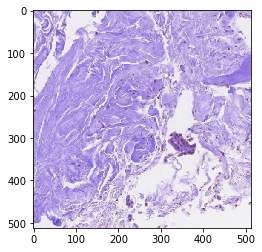

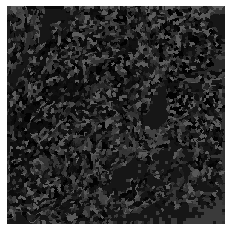

In [10]:
myDataLoader.generate_csv(TRAIN_DIR)
args.csv_path = os.path.join(TRAIN_DIR, 'image_files_pilot.csv')

transformed_dataset = myDataLoader.SegDataset(csv_file=args.csv_path, transform=myDataLoader.Compose([myDataLoader.ToTensor()]))

dataloader = DataLoader(transformed_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
myDataLoader.show_patch(dataloader)

In [36]:
optimizer_encoder = optim.SGD(encoder.parameters(), lr=0.001, momentum=0.9)
for epoch in range(1, 2):
    train(epoch, dataloader, 0.25)
    label(epoch, files)
    scheduler.step()
    
    if (epoch+1)%10 == 0:
        save_checkpoint({
          'epoch': epoch + 1,
          'model_arch': model.__class__,
          'state_dict': model.state_dict(),
#           'optimizer' : optimizer.state_dict(),
        }, False, file_folder=MODEL_DIR)

[1][53/54][19]

In [37]:
TEST_DIR = os.path.join(parent_dir, 'test/')
assert os.path.exists(TEST_DIR), 'please make sure TEST_DIR exist'

OUTPUT_DIR = os.path.join(parent_dir, 'output/')
if not os.path.exists(OUTPUT_DIR): os.mkdir(OUTPUT_DIR)

aux_filename = 'tt_'
test(TEST_DIR, False, OUTPUT_DIR, aux_filename)

In [38]:
# save dict
save_checkpoint({
          'epoch': epoch + 1,
          'model_arch': model.__class__,
          'state_dict': model.state_dict(),
#           'optimizer' : optimizer.state_dict(),
        }, False, file_folder=MODEL_DIR)

In [ ]:
# load dict
checkpoint = torch.load(os.path.join(MODEL_DIR, 'checkpoint.pth.tar'), map_location=torch.device('cuda:0'))
model.load_state_dict(checkpoint['state_dict'])